In [11]:
import time, os, pickle
import joblib
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE


from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler,RobustScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from operator import itemgetter
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

from sklearn.feature_selection import RFECV


#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Allow long lines

In [12]:
# Specify the path to the CSV file in the parent directory
file_path = "../Dataset/pd_speech_features/pd_speech_features.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=',',skiprows=1)

# SMOTE

In [13]:
X=df.drop('class',axis=1)
y=df['class']
smote_df = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote_df.fit_resample(X, y)

In [14]:
unique, counts = np.unique(y, return_counts=True)
original_class_distribution = dict(zip(unique, counts))
unique, counts = np.unique(y_smote, return_counts=True)
resampled_class_distribution = dict(zip(unique, counts))

print("Original class distribution:", original_class_distribution)
print("Resampled class distribution:", resampled_class_distribution)

Original class distribution: {0: 192, 1: 564}
Resampled class distribution: {0: 564, 1: 564}


# Normalization

In [15]:
features = X_smote.columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the features
X_smote_scaled = pd.DataFrame(scaler.fit_transform(X_smote[features]), columns=features)

# Feature Selection with RFE

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote_scaled, y_smote, test_size=0.2, random_state=42)

# Apply Recursive Feature Elimination
rfe = RFE(estimator=clf, n_features_to_select=200, step=1)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = rfe.support_

# Get ranking of features
feature_ranking = rfe.ranking_

# Transform the data to include only the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train a model using selected features
clf.fit(X_train_selected, y_train)

# Evaluate the model
accuracy = clf.score(X_test_selected, y_test)
print("Accuracy with selected features:", accuracy)

Accuracy with selected features: 0.9557522123893806


In [17]:
def evaluate_classifiers(X_train, y_train, X_test, y_test, name):
    classifiers = {
        'SVM': {
            'model': SVC(),
            'param_grid': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'param_grid': {
                'n_estimators': [100, 200, 300],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'param_grid': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'param_grid': {
                'priors': [None, [0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]

            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'param_grid': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'param_grid': {
                'learning_rate': [0.1, 0.01],
                'max_depth': [3, 5, 7],
                'n_estimators': [100, 200, 300]
            }
        },
        'AdaBoost': {
            'model': AdaBoostClassifier(),
            'param_grid': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.1, 1, 10]
            }
        }
        
    }

    performance_metrics = {}
    models_folder = f"../Models/{name}"
    
    
    # Create the folder if it doesn't exist
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
        print(f"Folder '{models_folder}' created successfully.")

    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        param_grid = clf_info['param_grid']
        
        
        start = time.time()
        grid_search = GridSearchCV(clf, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_

        # Extract feature names
        feature_names = X_train.columns.tolist()
        
        # Save feature names to CSV
        feature_names_filename = os.path.join(models_folder, f"{clf_name}_feature_names.csv")
        pd.DataFrame(feature_names, columns=['Feature Names']).to_csv(feature_names_filename, index=False)
        
        y_pred = best_clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        time_execution = time.time() - start
        performance_metrics[clf_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'time_execution': time_execution,
            'best_params': grid_search.best_params_
        }
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc:.2f})')

        # Save the model
        filename = os.path.join(models_folder, f"{clf_name}.joblib")
        with open(filename, 'wb') as file:
            joblib.dump(best_clf, file, protocol=4)
            print(f"Model for {clf_name} saved.")
            
        print(f"Classification Report for {clf_name}:")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return performance_metrics

Folder '../Models/AllDatasetWithSmoteNormalizedRfe' created successfully.
Model for SVM saved.
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       109
           1       0.98      0.91      0.95       117

    accuracy                           0.95       226
   macro avg       0.95      0.95      0.95       226
weighted avg       0.95      0.95      0.95       226

[[107   2]
 [ 10 107]]
Model for Random Forest saved.
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       109
           1       0.98      0.89      0.93       117

    accuracy                           0.93       226
   macro avg       0.94      0.94      0.93       226
weighted avg       0.94      0.93      0.93       226

[[107   2]
 [ 13 104]]
Model for KNN saved.
Classification Report for KNN:
              precision    recall  f1-score   supp

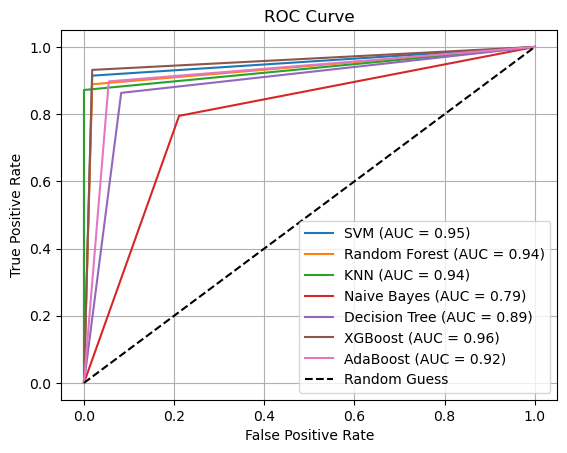

SVM Performance Metrics:
Accuracy: 0.9469026548672567
Precision: 0.981651376146789
Recall: 0.9145299145299145
F1 Score: 0.9469026548672567
AUC-ROC: 0.9480906453383517
Time: 13.465997457504272

Random Forest Performance Metrics:
Accuracy: 0.9336283185840708
Precision: 0.9811320754716981
Recall: 0.8888888888888888
F1 Score: 0.9327354260089686
AUC-ROC: 0.935270132517839
Time: 387.40867590904236

KNN Performance Metrics:
Accuracy: 0.9336283185840708
Precision: 1.0
Recall: 0.8717948717948718
F1 Score: 0.9315068493150686
AUC-ROC: 0.9358974358974359
Time: 3.0255675315856934

Naive Bayes Performance Metrics:
Accuracy: 0.7920353982300885
Precision: 0.8017241379310345
Recall: 0.7948717948717948
F1 Score: 0.7982832618025749
AUC-ROC: 0.791931310279934
Time: 1.0119168758392334

Decision Tree Performance Metrics:
Accuracy: 0.8893805309734514
Precision: 0.9181818181818182
Recall: 0.8632478632478633
F1 Score: 0.8898678414096917
AUC-ROC: 0.8903395279542069
Time: 23.708165168762207

XGBoost Performance 

In [18]:
results = evaluate_classifiers(X_train, y_train, X_test, y_test, "AllDatasetWithSmoteNormalizedRfe")

for clf_name, metrics in results.items():
    print(clf_name + " Performance Metrics:")
    print("Accuracy:", metrics['accuracy'])
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1 Score:", metrics['f1'])
    print("AUC-ROC:", metrics['auc'])
    print("Time:", metrics['time_execution'])
    print()